In [1]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

## create a connection

In [2]:
conn= sqlite3.connect('../data/checking-logs.sqlite')

## create a dataframe where each user of the test group has the average difference, number of pageviews and number of commits

do not take project1 into account for calculations of the average difference and the number of commits

take the number of commits from the checker table

In [3]:
query = '''
SELECT delta.uid,
       AVG(delta.delta) AS avg_diff,
       pageviews.num_views AS pageviews,
       commits.num_commits
FROM (
    SELECT uid,
           CAST((JulianDay(test.first_commit_ts) -
                 JulianDay(DATETIME(deadlines.deadlines, 'unixepoch'))
                 ) * 24 AS Integer) AS delta
    FROM test
    LEFT JOIN deadlines ON test.labname = deadlines.labs
    WHERE labname <> 'project1'
) AS delta
LEFT JOIN (
    SELECT uid, COUNT(*) AS num_views
    FROM pageviews
    WHERE uid LIKE 'user_%'
    GROUP BY uid
) AS pageviews ON delta.uid = pageviews.uid
LEFT JOIN (
    SELECT uid, COUNT(*) AS num_commits
    FROM checker
    WHERE uid LIKE 'user_%'
    AND labname <> 'project1'
    GROUP BY uid
) AS commits ON delta.uid = commits.uid
GROUP BY delta.uid
'''
df = pd.read_sql(query, conn)
df

,uid,avg_diff,pageviews,num_commits
0,user_1,-64.400000,28,62
1,user_10,-74.800000,89,20
2,user_14,-159.000000,143,61
3,user_17,-61.600000,47,51
4,user_18,-5.666667,3,5
5,user_19,-98.750000,16,118
6,user_21,-95.500000,10,65
7,user_25,-92.600000,179,79
8,user_28,-86.400000,149,60
9,user_3,-105.400000,317,18


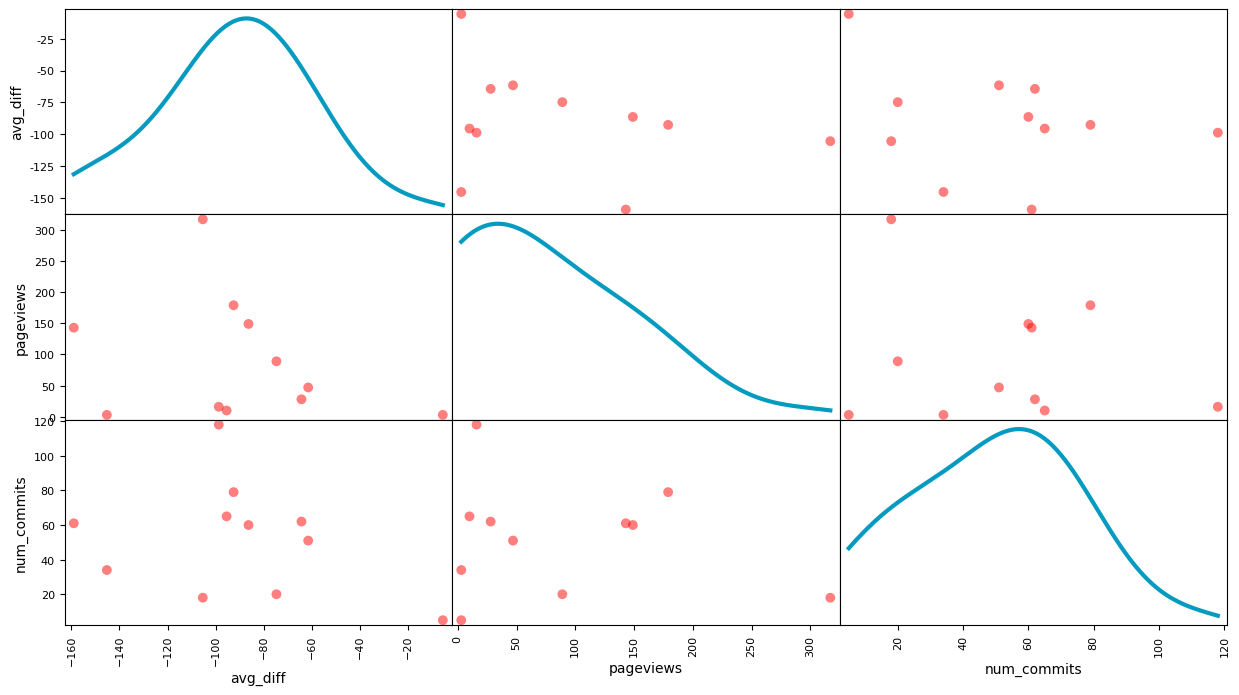

In [4]:
ax = scatter_matrix(df,
                    figsize=(15, 8),
                    diagonal='kde',
                    density_kwds=dict(color='#059ABF', linewidth=3),
                    s=200,
                    color='red')

## Can we say that if a user has a low number of pageviews then they likely have a low number of commits?” The answer: no.

## “Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?” The answer: no.

## “Can we say that there are many users with a low number of commits and a few with a high number of commits”? The answer: yes

## “Can we say that there are many users with a small average difference and a few with a large average difference”? The answer: no.

## close the connection

In [5]:
conn.close()